In [9]:
# --- ) Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix, roc_curve
)

import joblib

print("imports ✅")


imports ✅


In [10]:
X_train = np.load("../data/processed/X_train.npy")
X_test  = np.load("../data/processed/X_test.npy")
y_train = np.load("../data/processed/y_train.npy")
y_test  = np.load("../data/processed/y_test.npy")

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (5634, 51)  Test: (1409, 51)


In [11]:
def evaluate(model, X_test, y_test, model_name="Model", save_dir="../charts"):
    """Print metrics and save + show ROC + Confusion Matrix"""
    import os
    os.makedirs(save_dir, exist_ok=True)  # create folder if not exists
    
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred  = (y_proba >= 0.5).astype(int)
    
    # Metrics
    print(f"\n--- {model_name} ---")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("ROC AUC  :", roc_auc_score(y_test, y_proba))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    cm_path = os.path.join(save_dir, f"{model_name}_confusion_matrix.png")
    plt.savefig(cm_path, dpi=300, bbox_inches="tight")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={roc_auc_score(y_test, y_proba):.2f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    roc_path = os.path.join(save_dir, f"{model_name}_roc_curve.png")
    plt.savefig(roc_path, dpi=300, bbox_inches="tight")
    plt.show()
    
    print(f"Saved confusion matrix → {cm_path}")
    print(f"Saved ROC curve       → {roc_path}")



--- Logistic Regression ---
Accuracy : 0.7437899219304471
Precision: 0.5110356536502547
Recall   : 0.8048128342245989
F1 Score : 0.6251298026998962
ROC AUC  : 0.8447441163553695

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.81      1035
           1       0.51      0.80      0.63       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.74      0.76      1409



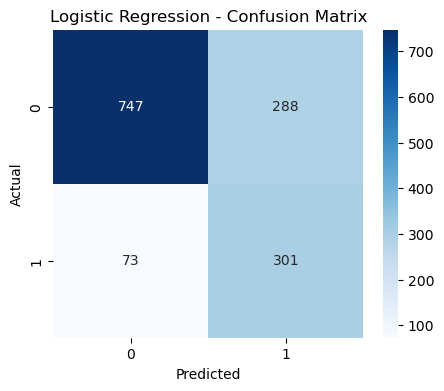

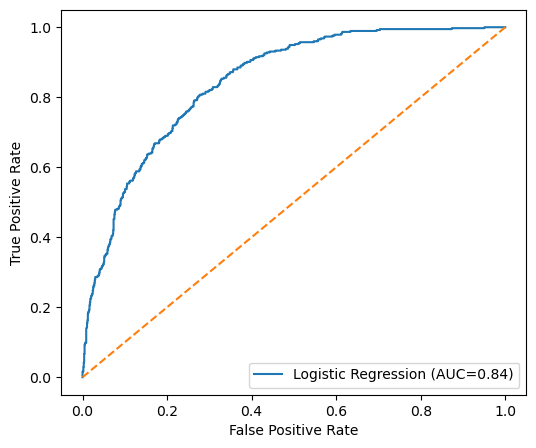

Saved confusion matrix → ../charts/Logistic Regression_confusion_matrix.png
Saved ROC curve       → ../charts/Logistic Regression_roc_curve.png


['../models/Logistic_Regression.joblib']

In [12]:
lr = LogisticRegression(max_iter=2000, class_weight="balanced")
lr.fit(X_train, y_train)
evaluate(lr, X_test, y_test, "Logistic Regression")
# Save model
joblib.dump(lr, f"../models/{"Logistic Regression".replace(' ','_')}.joblib")


Best Random Forest Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10}

--- Random Forest (Tuned) ---
Accuracy : 0.7629524485450674
Precision: 0.5381679389312977
Recall   : 0.7540106951871658
F1 Score : 0.6280623608017817
ROC AUC  : 0.8426954971712005

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.77      0.83      1035
           1       0.54      0.75      0.63       374

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409



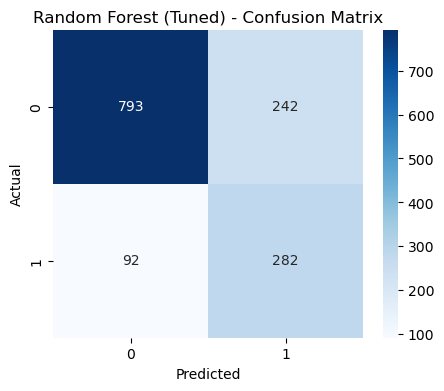

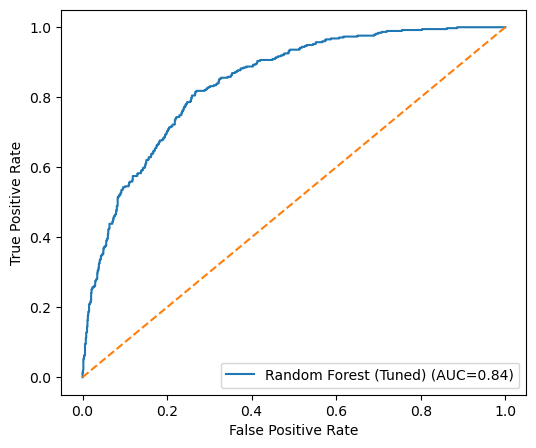

Saved confusion matrix → ../charts/Random Forest (Tuned)_confusion_matrix.png
Saved ROC curve       → ../charts/Random Forest (Tuned)_roc_curve.png


['../models/Random_Forest.joblib']

In [13]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

# Hyperparameter search space
param_dist = {
    "n_estimators": [100, 300, 500],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

rf_search = RandomizedSearchCV(
    rf, param_distributions=param_dist,
    n_iter=15, cv=3, scoring="roc_auc", n_jobs=-1, random_state=42
)

rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print("Best Random Forest Params:", rf_search.best_params_)

evaluate(best_rf, X_test, y_test, "Random Forest (Tuned)")

# Save model
joblib.dump(best_rf, f"../models/{"Random Forest".replace(' ','_')}.joblib")


Best Gradient Boosting Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}

--- Gradient Boosting ---
Accuracy : 0.8034066713981547
Precision: 0.6750902527075813
Recall   : 0.5
F1 Score : 0.5745007680491552
ROC AUC  : 0.8454080446407812

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.68      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



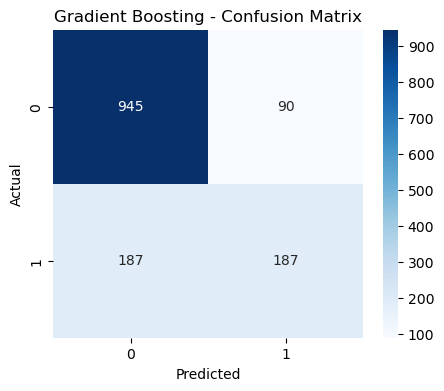

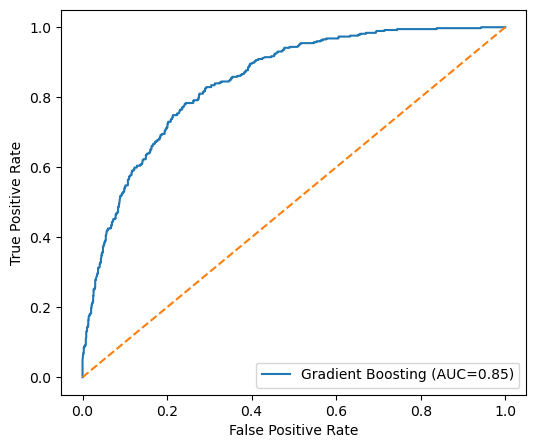

Saved confusion matrix → ../charts/Gradient Boosting_confusion_matrix.png
Saved ROC curve       → ../charts/Gradient Boosting_roc_curve.png
GradientBoostingClassifier model Evaluted ✅


In [14]:



gb = GradientBoostingClassifier(random_state=42)


param_dist_gb = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7]
}

gb_search = RandomizedSearchCV(
    gb, param_distributions=param_dist_gb,
    n_iter=10, cv=3, scoring="roc_auc", n_jobs=-1, random_state=42
)

gb_search.fit(X_train, y_train)
best_gb = gb_search.best_estimator_
print("Best Gradient Boosting Params:", gb_search.best_params_)

evaluate(best_gb, X_test, y_test, "Gradient Boosting")

print("GradientBoostingClassifier model Evaluted ✅")

In [ ]:

# Ensure output folder exists
save_dir = "../charts"
os.makedirs(save_dir, exist_ok=True)

# Feature importance plot
importances = pd.Series(best_rf.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
sns.barplot(x=top_features.values, y=top_features.index, orient="h")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")

# Save before show
fig_path = os.path.join(save_dir, "random_forest_top15_features.png")
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved feature importance plot → {fig_path}")



In [ ]:
# Compare models by ROC AUC
models = {
    "Logistic Regression": lr,
    "Random Forest": best_rf,
    "Gradient Boosting": best_gb
}

scores = {name: roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
          for name, model in models.items()}

best_model_name = max(scores, key=scores.get)
best_model = models[best_model_name]

print("Best model:", best_model_name, "with ROC AUC:", scores[best_model_name])

# Save model
joblib.dump(best_model, f"../models/{best_model_name.replace(' ','_')}.joblib")
